In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import setigen as stg
from astropy import units as u
import blimpy as bl
from astropy.time import Time
import extract_signals as es

import numpy as np
import soundfile as sf
import librosa

In [2]:
file_list = []
height_ratios = []
for i, row in es.DRIFTS.iterrows():
    filename = row['filename']
    full_path = f'{es.DATA_PREFIX}/{filename}'.replace('blcxx', 
                                                       es.META.loc[0]['node'])
    file_list.append(full_path)

    container = bl.Waterfall(full_path, load_data=False).container
    tchans = container.file_shape[0]
    dt = container.header['tsamp']
    height_ratios.append(tchans * dt)

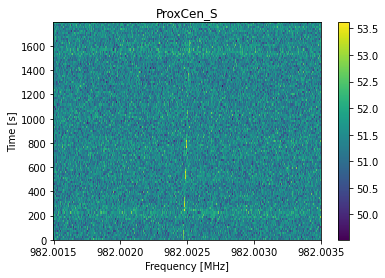

In [3]:
fr = stg.Frame(bl.Waterfall(file_list[4],
                            f_start=982.0015,
                            f_stop=982.0035))
fr.bl_plot()

(107, 525)

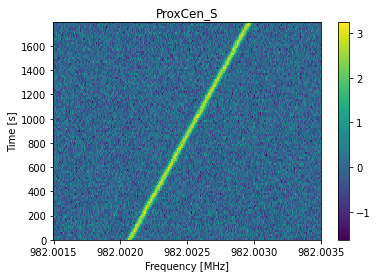

In [55]:
fr_s = fr.copy()
fr_s.zero_data()
fr_s.add_noise(1)
fr_s.add_constant_signal(fr_s.get_frequency(150),
                         drift_rate=0.5,
                         level=fr_s.get_intensity(snr=100),
                        width=40,
                        f_profile_type='sinc2')
fr_s.bl_plot()
fr_s.shape

In [56]:
S = librosa.griffinlim(fr_s.data.T)
S.shape

(27772,)

In [57]:
audiorate = 44100//4
sf.write('test.wav', S, audiorate, subtype='PCM_24')

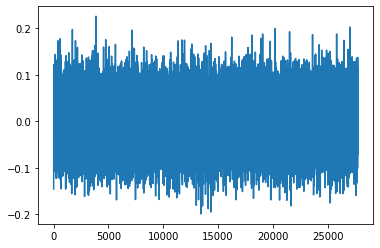

In [58]:
plt.plot(S)

In [4]:
sample_rate = 44100
stream = stg.voltage.DataStream(sample_rate=sample_rate)
stream.add_constant_signal(f_start=264, drift_rate=50, level=1)

S = stream.get_samples(sample_rate*5)
sf.write('test_voltage.wav', S, sample_rate, subtype='PCM_24')

In [5]:
def modulated_signal(ts):
    f_start = 264
    drift_rate = 50
#     level = 1
    phase = 0
    intensity_freq = 1 / 1
    level = (1 + np.cos(2*np.pi*intensity_freq*ts))/2
    
    chirp_phase = 2 * np.pi * ((f_start - 0) * ts + 0.5 * drift_rate * ts**2)
    return level * np.cos(chirp_phase + phase)

sample_rate = 44100
stream = stg.voltage.DataStream(sample_rate=sample_rate)
stream.add_signal(modulated_signal)


S = stream.get_samples(sample_rate*5)
sf.write('test_voltage.wav', S, sample_rate, subtype='PCM_24')

try to replicate blc1 signal

In [6]:
filename = es.DRIFTS.loc[0]['filename']
full_path = f'{es.DATA_PREFIX}/{filename}'.replace('blcxx', 
                                                   es.META.loc[0]['node'])

container = bl.Waterfall(full_path, load_data=False).container
tchans = container.file_shape[0]
df = container.header['foff']
dt = container.header['tsamp']
df, dt

(3.814697265625e-06, 16.777216)

In [7]:
def convert_freq(f):
    middle_C = 264
    return 0.5*middle_C+(f-982.0015)/(982.0035-982.0015)*(2*middle_C-0.5*middle_C)

In [15]:
np.linspace(0, 10, 20, endpoint=False)

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
       6.5, 7. , 7.5, 8. , 8.5, 9. , 9.5])

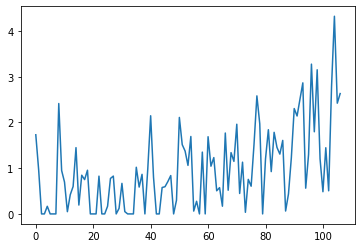

2.218129646659958


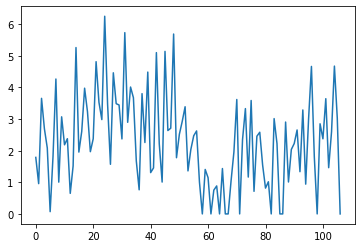

2.1582957062876327


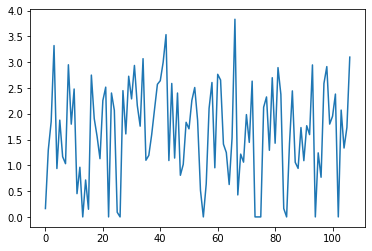

2.1782403530784102


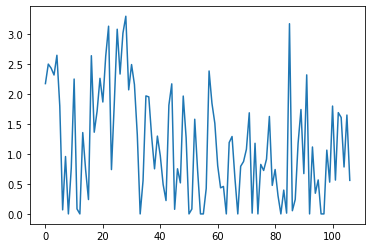

1.9189599447983086


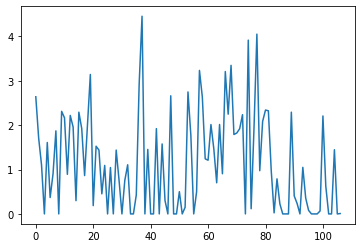

0.7322534607470899


In [42]:
sample_rate = 44100
all_y = np.load('intensity_data.npy', allow_pickle=True)
ts_info = np.load('ts_info.npy', allow_pickle=True).item()
candidate = all_y[0]['signal']

def convert_freq(f):
    middle_C = 264
    return 0.5*middle_C+(f-982.0015)/(982.0035-982.0015)*(2*middle_C-0.5*middle_C)

def convert_drift_rate(dr):
    middle_C = 264
    return dr/((982.0035-982.0015)*1e6)*(2*middle_C-0.5*middle_C)

synth_audio = []
for i, ts in enumerate(ts_info['ts_list']):
    stream = stg.voltage.DataStream(sample_rate=sample_rate)
    stream.add_noise(0, 0.1)
        
        
    ys = candidate[i]['scaled_ys']
    if ys is not None:
        # manual scaling; 5 seconds for ON pointing
        audio_len = 5 * len(ts) / 107
        ts = np.arange(len(ts)) / len(ts) * audio_len
        
        # Arbitrary scaling!
        ys = np.maximum(ys, 0) / 2
        plt.plot(ys)
        plt.show()
        
        # Adjust starting frequency and drift rate for different time/frequency scalings
        f_start = convert_freq(candidate[i]['center_freq'])
        drift_rate = convert_drift_rate(candidate[i]['drift_rate']) * (len(ts) * dt) / audio_len
        print(drift_rate)
        
        def modulated_signal(audio_ts):
            phase = 0
            
            level = ys[np.digitize(audio_ts, ts) - 1]
            chirp_phase = 2 * np.pi * ((f_start - 0) * audio_ts + 0.5 * drift_rate * audio_ts**2)
            return level * np.cos(chirp_phase + phase)

        
        stream.add_signal(modulated_signal)

    S = stream.get_samples(int(sample_rate * audio_len))
    
    # add blip before sound
    synth_audio.append([0]*(sample_rate//5))
    synth_audio.append(S)
    
        
S = np.concatenate(synth_audio)
sf.write(f'test_voltage_full.wav', S, sample_rate, subtype='PCM_24')

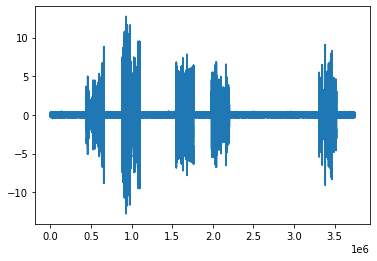

In [36]:
plt.plot(S)

In [20]:
np.arange(10)[[1,2,2,2,2]]

array([1, 2, 2, 2, 2])

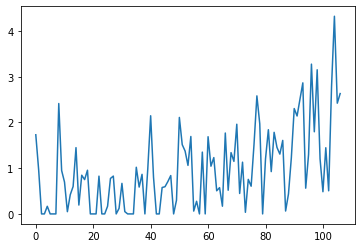

2.218129646659958


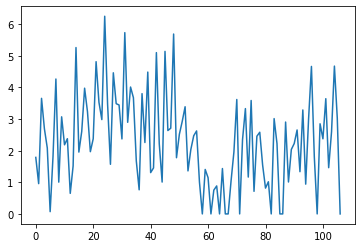

2.1582957062876327


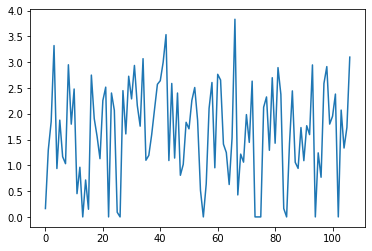

2.1782403530784102


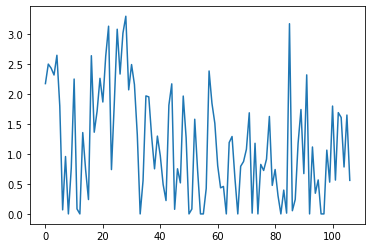

1.9189599447983086


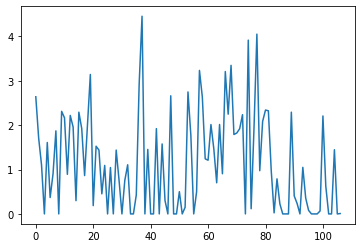

0.7322534607470899


In [43]:
from scipy.interpolate import splev, splrep

sample_rate = 44100
all_y = np.load('intensity_data.npy', allow_pickle=True)
ts_info = np.load('ts_info.npy', allow_pickle=True).item()
candidate = all_y[0]['signal']

def convert_freq(f):
    middle_C = 264
    return 0.5*middle_C+(f-982.0015)/(982.0035-982.0015)*(2*middle_C-0.5*middle_C)

def convert_drift_rate(dr):
    middle_C = 264
    return dr/((982.0035-982.0015)*1e6)*(2*middle_C-0.5*middle_C)

synth_audio = []
for i, ts in enumerate(ts_info['ts_list']):
    stream = stg.voltage.DataStream(sample_rate=sample_rate)
    stream.add_noise(0, 0.1)
        
        
    ys = candidate[i]['scaled_ys']
    if ys is not None:
        # manual scaling; 5 seconds for ON pointing
        audio_len = 5 * len(ts) / 107
        ts = np.arange(len(ts)) / len(ts) * audio_len
        
        # Arbitrary scaling!
        ys = np.maximum(ys, 0) / 2
        plt.plot(ys)
        plt.show()
        
        # Adjust starting frequency and drift rate for different time/frequency scalings
        f_start = convert_freq(candidate[i]['center_freq'])
        drift_rate = convert_drift_rate(candidate[i]['drift_rate']) * (len(ts) * dt) / audio_len
        print(drift_rate)
        
        def modulated_signal(audio_ts):
            phase = 0
            
            spl = splrep(ts, ys)
            level = splev(audio_ts, spl)
#             level = ys[np.digitize(audio_ts, ts) - 1]
            chirp_phase = 2 * np.pi * ((f_start - 0) * audio_ts + 0.5 * drift_rate * audio_ts**2)
            return level * np.cos(chirp_phase + phase)

        
        stream.add_signal(modulated_signal)

    S = stream.get_samples(int(sample_rate * audio_len))
    
    # add blip before sound
    synth_audio.append([0]*(sample_rate//5))
    synth_audio.append(S)
    
        
S = np.concatenate(synth_audio)
sf.write(f'test_voltage_full_spline.wav', S, sample_rate, subtype='PCM_24')

22.18129646659958
21.582957062876325
21.7824035307841
19.189599447983085
7.322534607470899


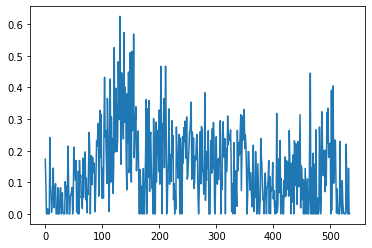

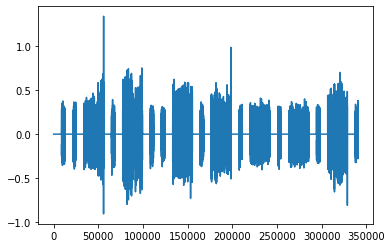

In [57]:
from scipy.interpolate import splev, splrep

sample_rate = 44100
all_y = np.load('intensity_data.npy', allow_pickle=True)
ts_info = np.load('ts_info.npy', allow_pickle=True).item()
candidate = all_y[0]['signal']

def convert_freq(f):
    middle_C = 264
    return 0.5*middle_C+(f-982.0015)/(982.0035-982.0015)*(2*middle_C-0.5*middle_C)

def convert_drift_rate(dr):
    middle_C = 264
    return dr/((982.0035-982.0015)*1e6)*(2*middle_C-0.5*middle_C)

synth_audio = []
yss = []
for i, ts in enumerate(ts_info['ts_list']):
    audio_len = 0.5 * len(ts) / 107
    stream = stg.voltage.DataStream(sample_rate=sample_rate)
    stream.add_noise(0, 0.1)
        
    ys = candidate[i]['scaled_ys']
    if ys is not None:
        # manual scaling; 5 seconds for ON pointing
        ts = np.arange(len(ts)) / len(ts) * audio_len
        
        # Arbitrary scaling!
        ys = np.maximum(ys, 0) / 2 / 10
        yss.append(ys)
        
        # Adjust starting frequency and drift rate for different time/frequency scalings
        f_start = convert_freq(candidate[i]['center_freq'])
        drift_rate = convert_drift_rate(candidate[i]['drift_rate']) * (len(ts) * dt) / audio_len
        print(drift_rate)
        
        def modulated_signal(audio_ts):
            phase = 0
            
            spl = splrep(ts, ys)
            level = splev(audio_ts, spl)
#             level = ys[np.digitize(audio_ts, ts) - 1]
            chirp_phase = 2 * np.pi * ((f_start - 0) * audio_ts + 0.5 * drift_rate * audio_ts**2)
            return level * np.cos(chirp_phase + phase)

        
        stream.add_signal(modulated_signal)

    S = stream.get_samples(int(sample_rate * audio_len))
    
    # add blip before sound
    synth_audio.append([0]*(sample_rate//5))
    synth_audio.append(S)
    
        
S = np.concatenate(synth_audio)
sf.write(f'voltage_full_spline_short.wav', S, sample_rate, subtype='PCM_24')


plt.plot(np.concatenate(yss))
plt.show()
plt.plot(S)
plt.show()

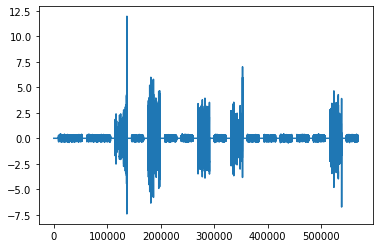